# Clssification With VGG16 in Raw Image

# Preparation

In [1]:
import numpy as np
import settings
from data_managers import load_train_dataset, load_test_dataset, make_submission
from keras.applications.vgg16 import VGG16
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Flatten
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from scipy.misc import toimage
import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.
Using gpu device 0: GeForce GTX 1080 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5105)
/home/liuweijie/workspace/FisheriesMonitor/.env/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
# fix random seed
seed = 7
np.random.seed(seed)

In [3]:
# setting variables
img_size = settings.image_size
model_filename = '../caches/vgg16_ncfm.h5'
submission_file = "../results/submission_vgg16.csv"
nb_epoch = 20
batch_size = 5

## Load Dataset

Loading train dataset ...
Finish loading train dataset:
X_train:  (3777, 3, 512, 512)
Y_train:  (3777,)
Loading test dataset ...
Finish loading test dataset:
X_test:  (1000, 3, 512, 512)
img_names:  (1000,)


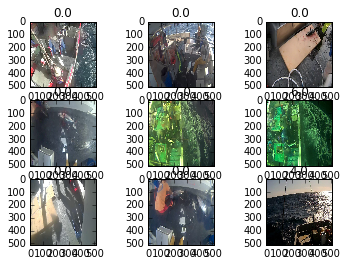

In [4]:
# load dataset
X, Y = load_train_dataset(verbose=1)
X_test, img_names = load_test_dataset(verbose=1)

# translate scale from 0-255 to 0-1
X = X / 255
X_test = X_test / 255

# split dataset
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=seed)

# trans Y_train to one-hot-vectory
Y_train_vec = to_categorical(Y_train)
Y_val_vec = to_categorical(Y_val)

# some parameters
num_classes = Y_train_vec.shape[1]

# show some images
for i in range(0, 9):
    plt.subplot(331 + i)
    plt.imshow(np.rollaxis(X_train[i], 0, 3))
    plt.title(str(Y_train[i]))
plt.show()

## Build Model

In [5]:
# Build a vgg16 without top layer
base_model = VGG16(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(input=base_model.input, output=predictions)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
print model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, None, None) 0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 64, None, None 1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 64, None, None 36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 64, None, None 0           block1_conv2[0][0]               
___________________________________________________________________________________________

## Train Model

In [8]:
# training model
checkpoint = ModelCheckpoint(model_filename, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
model.fit(X_train, Y_train_vec, validation_data=(X_val, Y_val_vec),
          nb_epoch=nb_epoch, batch_size=batch_size, callbacks=[checkpoint], verbose=1)

Train on 3021 samples, validate on 756 samples
Epoch 1/20
  75/3021 [..............................] - ETA: 431s - loss: 8.7562 - acc: 0.4133

KeyboardInterrupt: 

## Predict

In [ ]:
# load model and predict
model.load_weights(model_filename)
Y_test = model.predict(X_test, batch_size=batch_size, verbose=1)

## Save Result

In [ ]:
# load model
make_submission(submission_file, Y_test, img_names)

In [ ]:
print Y_train[0:100]